### Import libraries

In [1]:
import sys
sys.path.append("../..")

In [102]:
import collections
import dataclasses
import random
from typing import Optional

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as t
from days.atari_wrappers import AtariWrapper
from IPython.display import Video
from torch import nn, optim
from tqdm.auto import tqdm
from einops import reduce, repeat, rearrange

import rl_tests
from video_recorder import VideoRecorder

### Q-Network

In [3]:
class QNet(nn.Module):
    def __init__(
        self,
        in_size: int,
        hidden_size: int,
        out_size: int,
    ):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
        )

    def forward(
        self,
        obs: t.Tensor,  # Tensor[..., obs_shape]
    ) -> t.Tensor:
        """
        return: Tensor[..., num_actions]
        """
        return self.seq(obs)

    @property
    def device(self):
        return next(self.parameters()).device
    
    @property
    def dtype(self):
        return next(self.parameters()).dtype


rl_tests.test_q_net(QNet)

test_q_net MATCH!!!!!!!!
 SHAPE (16, 6) MEAN: -0.01521 STD: 0.1154 VALS [-0.04525 0.0126 -0.209 -0.02562 0.05611 0.1091 -0.04506 0.03364 -0.2371 -0.00214...]


### DQN eval loop

In [124]:
def make_choice(
    env: gym.Env,
    eps: float,
    net: nn.Module,
    obs: np.ndarray,
) -> int:
    """Returns one epsilon-greedy action."""

    # With probability eps return uniformly random action.
    if t.rand(1) < eps:
        return env.action_space.sample()

    q_vals = net(t.tensor(obs, dtype=net.dtype, device=net.device))
    # assert len(q_vals.shape) == 1

    return t.argmax(q_vals).item()

In [5]:
def evaluate(
    model: nn.Module,
    env: gym.Env,
    eps: float = 0,
    # gamma: float = 1.0,
    video_path: Optional[str] = None,
) -> float:
    """
    Runs model for one episode.
    Returns reward.
    """
    if video_path is not None:
        recorder = VideoRecorder(env, video_path)

    with t.no_grad():
        steps = 0
        obs = env.reset()
        total_reward = 0.0
        done = False
        while not done:
            if video_path is not None:
                recorder.capture_frame()

            obs, reward, done, _ = env.step(
                make_choice(env=env, eps=eps, net=model, obs=obs)
            )
            total_reward += reward
            steps += 1

    if video_path is not None:
        recorder.close()
    return total_reward, steps

In [6]:
env = gym.make("CartPole-v1")
evaluate(
    QNet(4, 64, env.action_space.n),
    env,
    video_path="videos/test_cartpole.mp4",
)

(9.0, 9)

### DQN train loop

In [55]:
@dataclasses.dataclass
class BufferEntry:
    obs: np.ndarray
    obs_next: np.ndarray
    action: int
    reward: float
    done: bool


def dqn_train(
    model: nn.Module,
    env_name: str,
    n_steps: int,
    batch_size: int,
    max_buffer_size: int = 10_000,
    train_freq: int = 10,
    eval_freq: int = 100,
    eps: float = 0.5,
    eps_end: float = None,
    gamma: float = 1.0,
    lr: float = 1e-3,
    seed: int = 42,
):
    if eps_end == None:
        eps_end = eps
    print(f"eps: {eps}")
    env: gym.Env = gym.make(env_name)
    env.seed(seed)
    env.action_space.seed(seed)

    opt = optim.Adam(model.parameters(), lr=lr)
    buffer = collections.deque(maxlen=max_buffer_size)

    perf_history: list[float] = []
    loss_history: list[float] = []
    obs: np.ndarray = env.reset()
    for i in tqdm(range(n_steps)):
        action = make_choice(env=env, eps=eps * (1 - i / n_steps) + eps_end * (i / n_steps), net=model, obs=obs)
        obs_next, reward, done, _ = env.step(action)
        if done:
            obs_next = env.reset()

        buffer.append(
            BufferEntry(
                obs=obs,
                obs_next=obs_next,
                action=action,
                reward=reward,
                done=done,
            )
        )
        obs = obs_next

        if i % train_freq == 0 and i >= batch_size:

            batch_entries: list[BufferEntry] = random.sample(buffer, batch_size)

            batch_obs = t.tensor(
                np.array([e.obs for e in batch_entries]),
                dtype=model.dtype,
                device=model.device,
            )
            batch_obs_next = t.tensor(
                np.array([e.obs_next for e in batch_entries]),
                dtype=model.dtype,
                device=model.device,
            )

            batch_terminal = t.tensor(
                [e.done for e in batch_entries], device=model.device, dtype=t.bool
            )
            batch_reward = t.tensor(
                [e.reward for e in batch_entries], device=model.device
            )

            with t.no_grad():
                q_next_best = t.amax(model(batch_obs_next), dim=-1)
                y = batch_reward + gamma * (~batch_terminal) * q_next_best

            action_idxs = t.tensor(
                [e.action for e in batch_entries], dtype=t.long, device=model.device
            )
            q = t.gather(model(batch_obs), 1, action_idxs.unsqueeze(dim=1)).flatten()
            loss = ((q - y) ** 2).mean()
            loss_history.append(loss.item())

            # import pdb

            # pdb.set_trace()

            opt.zero_grad()
            loss.backward()
            opt.step()

        if i % eval_freq == 0:
            fresh_env = gym.make(env_name)
            fresh_env.seed(seed)
            fresh_env.action_space.seed(seed)

            reward, steps = evaluate(model, fresh_env, eps=0)
            perf_history.append(reward)
    return loss_history, perf_history

### CartPole

In [11]:
SEED = 42
t.manual_seed(SEED)
random.seed(SEED)

env = gym.make("CartPole-v1")
model = QNet(
    in_size=env.observation_space.shape[0],
    hidden_size=64,
    out_size=env.action_space.n,
).cuda()

loss_history, perf_history = dqn_train(
    model=model,
    env_name="CartPole-v1",
    n_steps=100_000,
    max_buffer_size=10_000,
    train_freq=16,
    batch_size=128,
    eps=0.5,
    gamma=0.98,
    lr=1e-3,
    seed=SEED,
)

eps: 0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

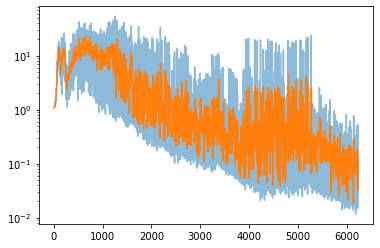

In [12]:
xs = pd.Series(loss_history)
xs.plot(alpha=0.5)
xs.rolling(10).mean().plot()
plt.yscale("log")

<AxesSubplot:>

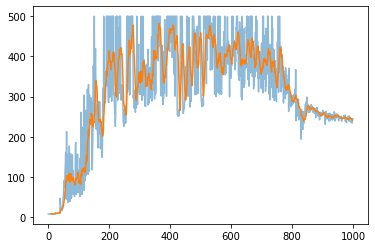

In [13]:
xs = pd.Series(perf_history)
xs.plot(alpha=0.5)
xs.rolling(10).mean().plot()

In [25]:
video_path = "videos/model_cartpole.mp4"
evaluate(model, env, video_path = video_path)
Video(video_path)

### AcroBot

In [26]:
env_acro.observation_space.shape

(6,)

In [27]:
env_acro.action_space.n

3

In [28]:
evaluate(model_acro, env_acro)

(-500.0, 500)

In [31]:
SEED = 42
t.manual_seed(SEED)
random.seed(SEED)

env_acro = gym.make("Acrobot-v1")
model_acro = QNet(
    in_size=env_acro.observation_space.shape[0],
    hidden_size=64,
    out_size=env_acro.action_space.n,
).cuda()

loss_history_acro, perf_history_acro = dqn_train(
    model=model_acro,
    env_name="Acrobot-v1",
    n_steps=25_000,
    max_buffer_size=10_000,
    train_freq=4,
    batch_size=128,
    eps=0.05,
    gamma=0.99,
    lr=1e-4,
    seed=SEED,
)

eps: 0.05


  0%|          | 0/25000 [00:00<?, ?it/s]

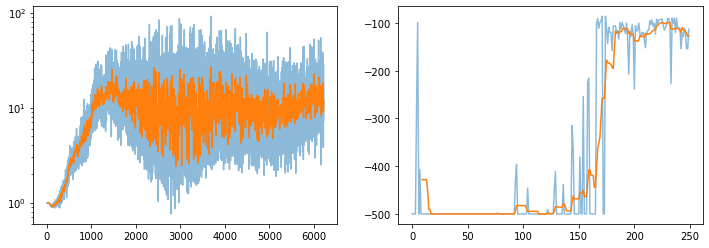

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
xs = pd.Series(loss_history_acro)
xs.plot(alpha=0.5)
xs.rolling(10).mean().plot()
plt.yscale("log")

plt.subplot(1, 2, 2)
xs = pd.Series(perf_history_acro)
xs.plot(alpha=0.5)
xs.rolling(10).mean().plot();

In [37]:
video_path = "videos/model_acro.mp4"
evaluate(model_acro, env_acro, video_path = video_path)
Video(video_path)

### Atari DQN

In [139]:
def prod(tensor):
    return t.exp(sum(map(lambda x : t.log(x), l)))

class AtariConv(nn.Module):
    def __init__(self, obs_n_channels, n_action_space):
        super().__init__()
        self.obs_n_channels = obs_n_channels
        self.n_action_space = n_action_space
        self.layers = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, n_action_space),
        )

    def forward(self, obs):
        print(obs.shape)
        if len(obs.shape) == 3:
            obs = rearrange(obs, "h w c -> c w h").unsqueeze(0)
        elif len(obs.shape) == 4:
            print("4d input")
            obs = rearrange(obs, "b h w c -> b c w h")
        else:
            print("weird-sized input in AtariConv")
        return self.layers(obs)

    @property
    def device(self):
        return next(self.parameters()).device

    @property
    def dtype(self):
        return next(self.parameters()).dtype

In [140]:
SEED = 42
t.manual_seed(SEED)
random.seed(SEED)

env_atari = gym.make("BreakoutNoFrameskip-v0")
env_atari = AtariWrapper(env_atari)
model_atari = AtariConv(
    4,
    env_atari.action_space.n
).cuda()


In [141]:
evaluate(model_atari, env_atari)

torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])
torch.Size([84, 84, 4])


(0.0, 23)

In [142]:

loss_history_atari, perf_history_atari = dqn_train(
    model=model_atari,
    env_name="BreakoutNoFrameskip-v0",
    n_steps=1_000,
    max_buffer_size=10_000,
    train_freq=4,
    batch_size=32,
    eps=1.0,
    eps_end=0.01,
    gamma=0.99,
    lr=1e-4,
    seed=SEED,
)

eps: 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([210, 160, 3])


RuntimeError: Given groups=1, weight of size [32, 4, 8, 8], expected input[1, 3, 160, 210] to have 4 channels, but got 3 channels instead

In [ ]:
env_atari.observation_space.shape


In [52]:
env_atari.action_space.n

4